In [1]:
import sys, os
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import pydub
import torch
import torch.nn as nn
from datasets import *
#import torchaudio
#from torchaudio import transforms
import h5py as hf

/home/fleeb/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [18]:
meta = torch.load('/home/fleeb/workspace/ml_datasets/audio/yt/meta/full_meta.pth.tar')
split = torch.load('/home/fleeb/workspace/ml_datasets/audio/yt/split.pth.tar')
meta.keys(), split.keys()

(dict_keys(['gids', 'mids', 'tracks']),
 dict_keys(['paths', 'lens', 'genre-loss-weights', 'genre-lbls', 'mood-lbls', 'mood-loss-weights']))

In [6]:
split['genre-loss-weights'] = split['loss-weights']
split['genre-lbls'] = split['lbls']
del split['loss-weights']
del split['lbls']
split.keys()

dict_keys(['paths', 'lens', 'genre-loss-weights', 'genre-lbls'])

In [8]:
moods = []
for paths in split['paths']:
    ms = []
    for p in paths:
        with hf.File(p, 'r') as f:
            ms.append(f.attrs['mid'])
    moods.append(np.array(ms))
    
[ms.shape for ms in moods]

[(1056,), (126,), (201,)]

In [10]:
split['mood-lbls'] = moods
nlens = split['lens']

In [13]:
loss_weight = nlens[0].sum() / np.bincount(moods[0], nlens[0], minlength=10)
loss_weight = torch.from_numpy(loss_weight).float()
loss_weight

tensor([10.4675,  4.9201, 27.2271, 25.4770, 22.3929,  6.8497,  7.5582, 10.6755,
         9.4675,  9.7101])

In [15]:
split['mood-loss-weights'] = loss_weight

In [16]:
split.keys()

dict_keys(['paths', 'lens', 'genre-loss-weights', 'genre-lbls', 'mood-lbls', 'mood-loss-weights'])

In [17]:
torch.save(split, '/home/fleeb/workspace/ml_datasets/audio/yt/split.pth.tar')

In [14]:
np.bincount(moods[0])

array([ 93, 206,  40,  46,  46, 176, 126, 110, 100, 113])

In [3]:
root = '/home/fleeb/workspace/ml_datasets/audio/yt'

In [26]:
songs = util.crawl(os.path.join(root, 'raw'), cond=lambda x: '.mp3' in x)
len(songs)

1289

In [5]:
for i, song in enumerate(songs):
    t, fs = load_mp3(song, normalize=True, cut_zeros=True)
    if fs == 44100:
        break
    print(i, fs)

0 48000
1 48000


In [11]:
song

'/home/fleeb/workspace/ml_datasets/audio/yt/raw/[Royalty Free Music] 10 Sleepless Nights - Olivaw.mp3'

In [1]:
#t, fs = load_mp3(songs[70], normalize=True, cut_zeros=True)
#print(fs)

NameError: name 'load_mp3' is not defined

In [6]:
t.shape[0] / fs

285.15546485260774

<IPython.core.display.Javascript object>


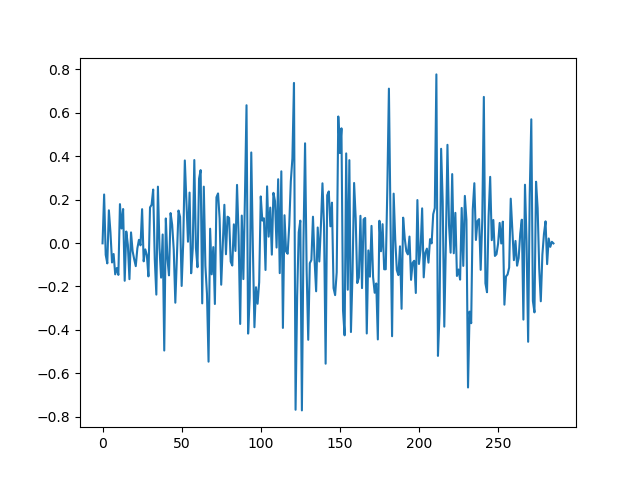

In [10]:
plt.figure()
plt.plot(t[::fs])

In [35]:
cmdtmp = 'sox {input} -r 44100 --norm {output}'

In [36]:
inp = '"' + song + '"'
out = inp[:-5] + '-test.mp3"'
out

'"/home/fleeb/workspace/ml_datasets/audio/yt/raw/Grass - Silent Partner (No Copyright Music)-test.mp3"'

In [37]:
outdir = os.path.join(root, 'clean')
outdir

'/home/fleeb/workspace/ml_datasets/audio/yt/clean'

In [38]:
cmds = []
for i, song in enumerate(songs):
    inp = '"' + song + '"'
    out = '"' + os.path.join(root, 'clean', os.path.basename(song)) + '"'
    cmds.append(cmdtmp.format(input=inp, output=out))
    if i % 10 == 0:
        cmds.append('echo "cleaning: {}/{} complete"'.format(i+1, len(songs)))
        
len(cmds)

1418

In [39]:
cmdpath = os.path.join(root, 'clean-cmds.sh')
with open(cmdpath, 'w') as f:
    f.write('\n'.join(cmds))
    f.write('\n')

print(cmdpath)

/home/fleeb/workspace/ml_datasets/audio/yt/clean-cmds.sh


In [24]:
t1, fs = load_mp3(out[1:-1], normalize=True, cut_zeros=True)
print(fs)

FileNotFoundError: [Errno 2] No such file or directory: '/home/fleeb/workspace/ml_datasets/audio/yt/raw/[Royalty Free Music] 10 Sleepless Nights - Olivaw-test.mp3'

In [20]:
t.shape, t1.shape

((12575356,), (12575314,))

In [22]:
t.max(), t.min()

(0.988494873046875, -0.988525390625)

In [23]:
t1.max(), t1.min()

(0.988494873046875, -0.988525390625)

<IPython.core.display.Javascript object>


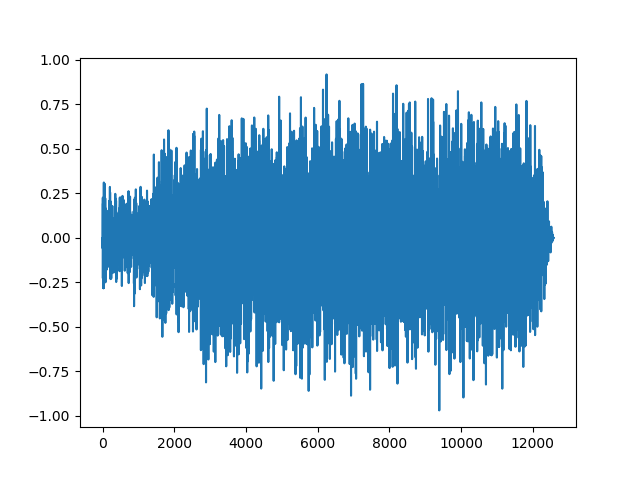

<IPython.core.display.Javascript object>


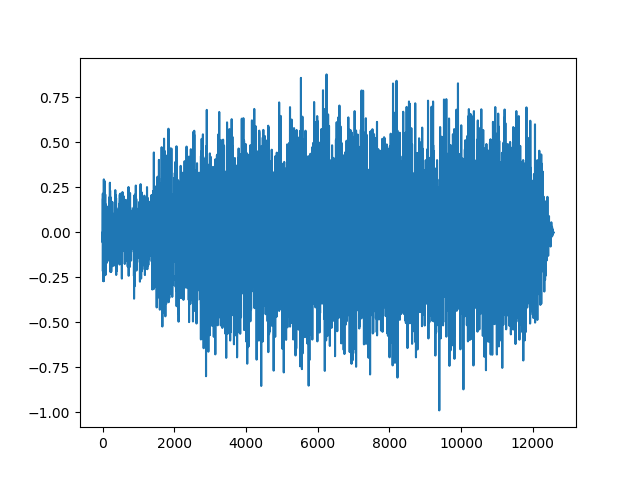

In [21]:
plt.figure()
plt.plot(t[::1000])
plt.figure()
plt.plot(t1[::1000])